In [1]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 5.6 MB/s 
     |████████████████████████████████| 62 kB 326 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
# Importando librerías
import numpy as np
import matplotlib. pyplot as plt
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import datetime as dt
import seaborn as sns
import matplotlib.dates as mdates
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

Se importa la librería "Import Data", la cual proporciona el precio del mercado para una acción.

In [3]:
# Importar el fichero .PY, el cual se conecta a Yahoo Finance e importa los datos
from google.colab import drive
drive.mount('/content/drive')

execfile('/content/drive/MyDrive/StockPrediction/import_data_stock_prediction.py')

Mounted at /content/drive


# LSTM Univariante

## Funciones

### Transformación de datos

In [4]:
def TransformData(tickerDf, split_data=0.8):
    data = tickerDf.filter(['Adj Close'])
    dataset = data.values

    # Separación de datos. Por defecto, 80% entrenamiento, 20% testeo
    training_data_len = math.ceil(len(dataset) * split_data)

    # Normalización de datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Crear set de datos de entrenamiento
    train_data = scaled_data[0:training_data_len, :]

    # Split
    x_train = []
    y_train = []

    for i in range(train_last_days, len(train_data)):
        x_train.append(train_data[i-train_last_days:i, 0])
        y_train.append(train_data[i, 0])
    
    # Convertir x_train y y_train a numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train, y_train, dataset, training_data_len, scaler, scaled_data

### Entrenamiento

In [5]:
def LSTM_Model(x_train, model_dropout=0.2, model_neuron=50, model_learning_rate=1e-4):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units = model_neuron,
                                    input_shape=(x_train.shape[1], 1),
                                    return_sequences=True))
    # Model 2 - 11
    model.add(tf.keras.layers.Dropout(model_dropout))
    model.add(tf.keras.layers.LSTM(units = model_neuron, return_sequences=True))
    model.add(tf.keras.layers.Dropout(model_dropout))
    model.add(tf.keras.layers.LSTM(units = model_neuron))
    model.add(tf.keras.layers.Dropout(model_dropout))
    model.add(tf.keras.layers.Dense(units=25))
    model.add(tf.keras.layers.Dense(units=1))

    # Model 1 - 5.9
    # model.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
    # model.add(tf.keras.layers.Dense(units=25))
    # model.add(tf.keras.layers.Dense(units=1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = model_learning_rate), 
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy']
              )
    
    return model

In [6]:
def LSTM_fit(model, x_train, y_train, model_epochs=30, model_batch_size=32):
    # Técnica de EarlyStopping para monitorizar la pérdida durante la validación cada 8 épocas
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='loss', 
        patience=8)

    history = model.fit(x_train, 
                y_train, 
                epochs = model_epochs, 
                batch_size = model_batch_size,
                validation_split = 0.1,
                callbacks = [early_stop],    
                verbose=0) # Verbose 0 para no mostrar las líneas
    
    return history

In [7]:
def LSTM_PlotLoss(mfit, n_epochs=30):
    N = len(mfit.history['accuracy'])
    plt.style.use("ggplot")
    fig, (ax2) = plt.subplots(1, 1, figsize=(10,5))
    fig.suptitle('Función de Pérdida')
      
    ax2.plot(np.arange(0, N), mfit.history["loss"], label="Pérdida en el Entrenamiento")
    ax2.plot(np.arange(0, N), mfit.history["val_loss"], label="Pérdida en la validación")
    ax2.set_title("Pérdida")
    ax2.set_xlabel("Nº Épocias")
    ax2.set_ylabel("Pérdida")
    ax2.legend(loc="upper right")
    
    plt.show()

### Testeo

In [8]:
def LSTM_Predictions(model, training_data_len, scaled_data, scaler, dataset):
    test_data = scaled_data[training_data_len - train_last_days:, :]

    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(train_last_days, len(test_data)):
        x_test.append(test_data[i-train_last_days:i, 0])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions, y_test

In [9]:
def LSTM_RMSE(predictions, y_test):
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    return rmse # Value of 0 means the model is exact

### Predicciones

In [10]:
import warnings
def LSTM_PlotPredictions(data, training_data_len, predictions):
    warnings.filterwarnings("ignore")

    train = data[:training_data_len]
    valid =  data[training_data_len:]
    valid['Predictions'] = predictions
    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date', fontsize = 18)
    plt.ylabel('Close Price', fontsize = 18)
    plt.plot(train['Adj Close'], color='RoyalBlue')
    plt.plot(valid['Adj Close'], color='Green')
    plt.plot(valid['Predictions'], color='Red')
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [11]:
def LSTM_PredictNextDay(tickerDf, scaler, model, train_last_days=60, last_day_predicted=0):
    if last_day_predicted == 0:
        tickerDf_test = tickerDf
    else:
        tickerDf_test = tickerDf.iloc[:-last_day_predicted,:]

    last_days = tickerDf_test.filter(['Adj Close'])

    # Obtenemos la fecha del día siguiente y el valor real asociado a esa fecha, si existe
    day = last_days[-1:].index
    day = day[0].strftime('%Y-%m-%d')
    day = datetime.strptime(day, '%Y-%m-%d')
    if last_day_predicted == 0:
        day = day + timedelta(days=1)
        real = 0
    else:
        day = tickerDf.loc[tickerDf.index >= day].iloc[1].name
        real = round(tickerDf['Adj Close'].loc[tickerDf.index == day].values[0], 2)

    last_days = last_days[-train_last_days:].values
    last_days_scaled = scaler.transform(last_days)

    X_test = []
    X_test.append(last_days_scaled)

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    prec = round(pred_price[0][0], 2)

    return day.strftime('%Y-%m-%d'), real, prec

## Llamada al modelo LSTM

### Descarga de datos y Parámetros

In [45]:
tickerSymbol = 'BA'

# Obtenemos los datos desde el día actual hasta hace 5 años
one_year_ago = datetime.now() - relativedelta(years=5)
start_date = one_year_ago.strftime('%Y-%m-%d')

#one_year_ago = datetime.now() - relativedelta(years=1)
end_date = datetime.now().strftime('%Y-%m-%d')

# Se obtiene el datafram de la empresa seleccionada y en el rango de fechas
tickerDf = GetStockDataByTicker(tickerSymbol, start_date, end_date)

In [46]:
GetStockInformationByTicker(tickerSymbol, start_date, end_date)

,Ticker,Short Name,Sector,Industry,Recommendation,Recommendation Mean,Target Low Price,Target High Price,Target Mean Price,Current Price,%,Volume,Average Volume,EBITDA,EBITDA Margins,Fecha Actualización,52 Week Change,SMA20,SMA50,SMA100,SMA200,EMA10
0,BA,Boeing Company (The),Industrials,Aerospace & Defense,none,None,None,None,None,201.32,0,8052980,9486400,-1328999936,-0.02116,2022-01-02 19:07,-0.006906,200.98,208.28,214.05,226.31,201.6


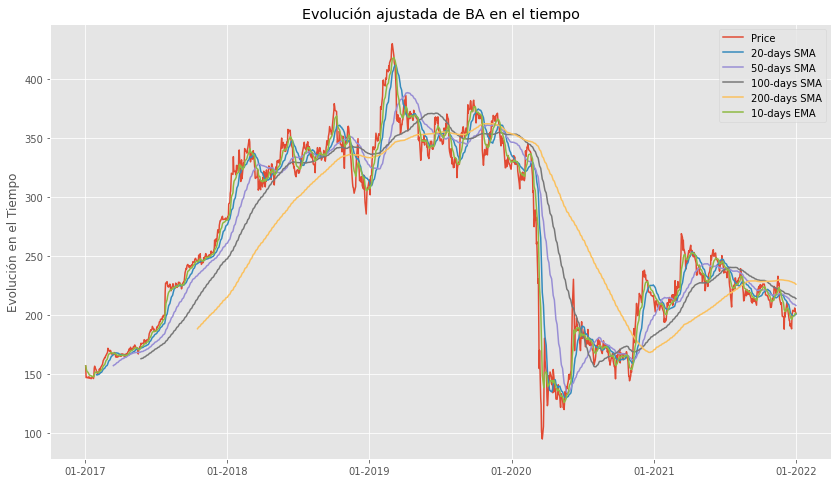

In [47]:
Graph_StockEvolutionByTime(tickerSymbol, tickerDf)

In [48]:
train_last_days = 60
split_data = 0.8 #80% train, 20% test

model_neuron = 50
model_epochs = 30 
model_batch_size = 32 
model_learning_rate = 1e-4
model_dropout = 0.2

### Transformación de datos

In [49]:
x_train, y_train, dataset, training_data_len, scaler, scaled_data = TransformData(tickerDf, split_data)

### Entrenamiento

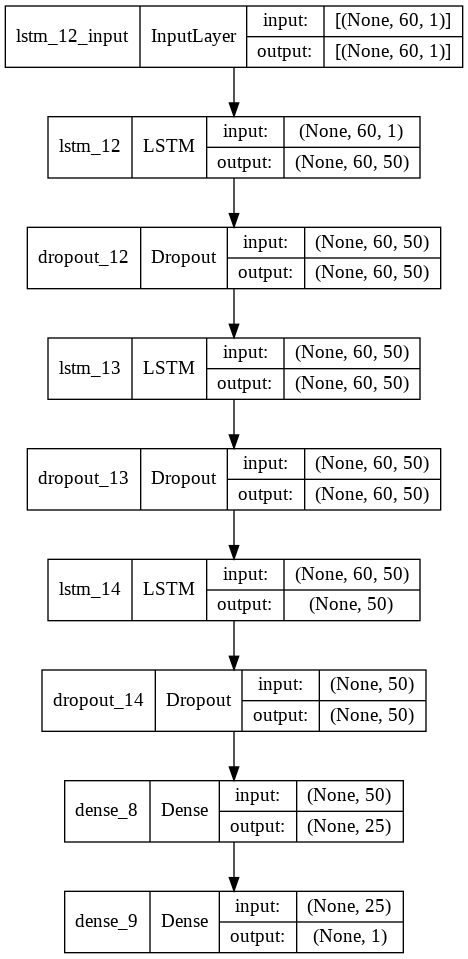

In [50]:
LSTM_model = LSTM_Model(x_train, model_dropout, model_neuron, model_learning_rate)
LSTM_history = LSTM_fit(LSTM_model, x_train, y_train, model_epochs, model_batch_size)

tf.keras.utils.plot_model(LSTM_model, show_shapes=True, show_layer_names=True)

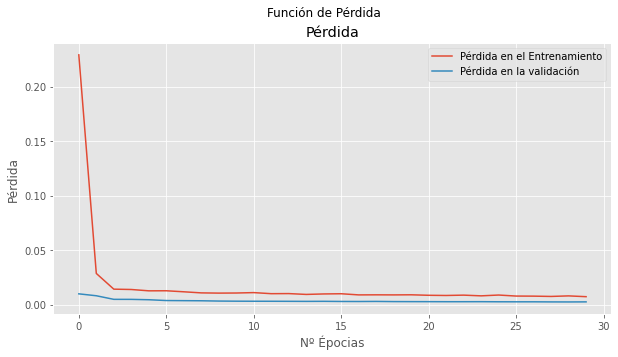

In [51]:
LSTM_PlotLoss(LSTM_history, model_epochs)

### Testeo

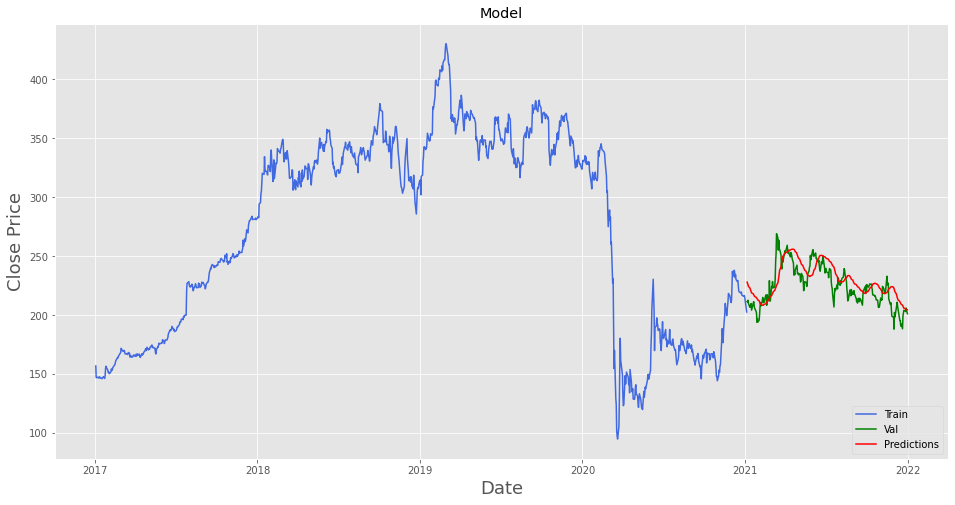

RSME =  4.921211273071775


In [52]:
predictions, y_test = LSTM_Predictions(LSTM_model, training_data_len, scaled_data, scaler, dataset)
LSTM_PlotPredictions(tickerDf.filter(['Adj Close']), training_data_len, predictions)
print("RSME = ", LSTM_RMSE(predictions, y_test))

### Predicción prox día

In [53]:
# Si last_day_predicted = 0, predice el precio del día siguiente
# Si last_day_predicted >= 1, compara el precio predecido con el real, siendo X la cantidad de días hacia atrás con el que comparar
last_day_predicted = 0

day, real, predicted = LSTM_PredictNextDay(tickerDf, scaler, LSTM_model, train_last_days, last_day_predicted)

# Imprimir resultados
if last_day_predicted != 0:
    # Comparación precio real vs predicción
    if (real > predicted):
        prec = abs(predicted/real*100)
    else:
        prec = (real/predicted)*100
    prec = round(prec, 2)

    print("El precio real del día", day, "es", real, ", y el predicho", predicted)
    print("La precisión es de", prec, "%")
else:
    print("Se estima que el precio de mañana de", tickerSymbol, "sea", predicted, "$")

Se estima que el precio de mañana de BA sea 204.84 $
